# Data Analysis

Here we will explore and analyze our data. 

### Dataset

Here we focus only on patient 559's blood glucose level during the 2018 study period

### Objectives

1. Analyze blood glucose values and try to understand some mechanisms of blood glucose evolution
2. Find patterns in our data 

### Loading and visualizing our data

In [2]:
# import of useful modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mpld
from datetime import date
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [5]:
# pre-processing
train_df = pd.read_csv('data/csv/2018/train/559-ws-training-glucose_level.csv')
test_df = pd.read_csv('data/csv/2018/test/559-ws-testing-glucose_level.csv')

train_df.index = pd.to_datetime(train_df['ts'], format = "%d-%m-%Y %H:%M:%S")
test_df.index = pd.to_datetime(test_df['ts'], format = "%d-%m-%Y %H:%M:%S")

train_df = train_df.drop('ts', axis=1)
test_df = test_df.drop('ts', axis=1)

FileNotFoundError: [Errno 2] No such file or directory: 'data/csv/2018/train/559-ws-training-glucose_level.csv'

In [ ]:
# data insights
print("Blood Glucose Level")
print(train_df.describe())

print("\nHead and tail of the serie")
print(train_df.head())
print(train_df.tail())

print("\nTemporal range of training & testing data: ") 
print("training: ", train_df.index.max() - train_df.index.min())
print("testing: ", test_df.index.max() - test_df.index.min())

Blood Glucose Level
              value
count  10796.000000
mean     166.692293
std       70.577174
min       40.000000
25%      108.000000
50%      157.000000
75%      212.000000
max      400.000000

Head and tail of the serie
                     value
ts                        
2021-12-07 01:17:00    101
2021-12-07 01:22:00     98
2021-12-07 01:27:00    104
2021-12-07 01:32:00    112
2021-12-07 01:37:00    120
                     value
ts                        
2022-01-17 23:36:00    161
2022-01-17 23:41:00    164
2022-01-17 23:46:00    168
2022-01-17 23:51:00    172
2022-01-17 23:56:00    176

Temporal range of training & testing data: 
training:  41 days 22:39:00
testing:  9 days 23:37:00


C:\Users\rapha\AppData\Local\Temp\ipykernel_2172\4063847060.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')


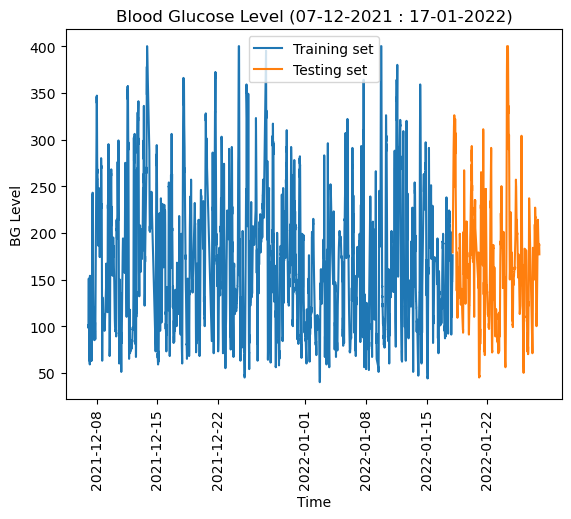

In [ ]:
# visualization
fig, ax = plt.subplots()
ax.plot(train_df.index, train_df['value'], label='Training set')
ax.plot(test_df.index, test_df['value'], label='Testing set')
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.title("Blood Glucose Level (07-12-2021 : 17-01-2022)")
plt.xlabel("Time")
plt.ylabel("BG Level")
ax.legend()
plt.show()

We can see **great variability** in our data, with BG level reaching significant hyperglycemic values (>250 mg/dL) several times. Out of curiosity, on these 7 and a half weeks of training data, we can look at the percentage of time spent in each glycemic zone by the individual.

In [ ]:
# extraction of blood glucose values >180 mg/dL
high_glyc = train_df.loc[train_df['value'] > 180]

# extraction of blood glucose values <80 mg/dL
low_glyc = train_df.loc[train_df['value'] < 80]

# percentages spent in hypoglycemia and hyperglycemia
print("Time spent with blood glucose above 180:", 100*len(high_glyc)/len(train_df['value']))
print("Time spent with blood glucose below 80:",100*len(low_glyc)/len(train_df['value']) )


Time spent with blood glucose above 180: 39.97776954427566
Time spent with blood glucose below 80: 7.743608743979252


Therefore, we notice that this individual is **40% of the time in hyperglycemia** and **7% of the time in hypoglycemia**, which means that he is in the **target zone only 53% of the time**.

This first indicator is a great way to get an idea of the glycemic balance of a diabetic. For this individual, it is therefore understandable that the usefulness of a decision support system could be greatly enhanced to try to maintain his or her blood sugar within the target zone. 

### Seasonal Decompose of the time series

Seasonal decompose is a method used to decompose the components of a time series into the following:
* Trend - increasing or decreasing value in the series.
* Seasonality - repeating short-term cycle in the series.
* Noise - random variation in the series.

The analysis of the components individually provide better insights for model selection.


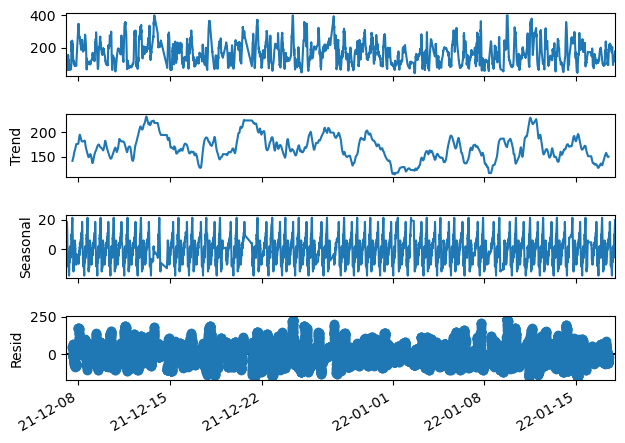

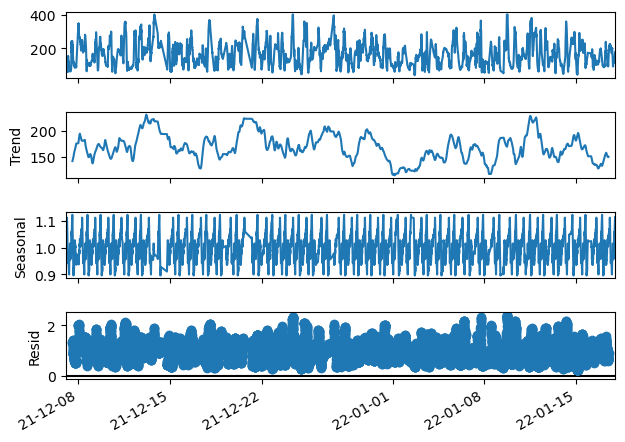

In [ ]:
# additive decomposition
result_add = seasonal_decompose(train_df, period=288, model='additive') # 288 = 24*60/5 <--> 24h-period
result_add.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)

# multiplicative decomposition
result_mul = seasonal_decompose(train_df, period=288, model='multiplicative')
result_mul.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()

Although these graphs are not very visible, we can already see that the series seems stationary (no particular trend), but that it seems to have a **seasonality**.

Let's try to reduce the time window to better perceive this seasonality. 

In [ ]:
# we first look at what happens on a weekly basis
week_1 = (train_df.index >= "2021-12-07") & (train_df.index <= "2021-12-14")
week_2 = (train_df.index >= "2021-12-14") & (train_df.index <= "2021-12-21")
week_3 = (train_df.index >= "2021-12-21") & (train_df.index <= "2021-12-28")
week_4 = (train_df.index >= "2021-12-28") & (train_df.index <= "2022-01-04")
week_5 = (train_df.index >= "2022-01-04") & (train_df.index <= "2022-01-11")
week_6 = (train_df.index >= "2022-01-11") 

week_1_df = train_df.loc[week_1]
week_2_df = train_df.loc[week_2]
week_3_df = train_df.loc[week_3]
week_4_df = train_df.loc[week_4]
week_5_df = train_df.loc[week_5]
week_6_df = train_df.loc[week_6]

# we then look at what happens on a daily basis
week_1_day_1_df = train_df.loc[train_df.index.date == date(2021,12,7)]
week_1_day_2_df = train_df.loc[train_df.index.date == date(2021,12,8)]
week_1_day_3_df = train_df.loc[train_df.index.date == date(2021,12,9)]
week_1_day_4_df = train_df.loc[train_df.index.date == date(2021,12,10)]
week_1_day_5_df = train_df.loc[train_df.index.date == date(2021,12,11)]
week_1_day_6_df = train_df.loc[train_df.index.date == date(2021,12,12)]
week_1_day_7_df = train_df.loc[train_df.index.date == date(2021,12,13)]

#### Week 1

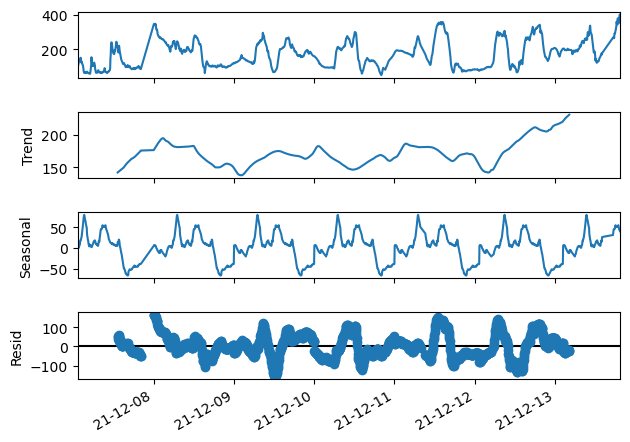

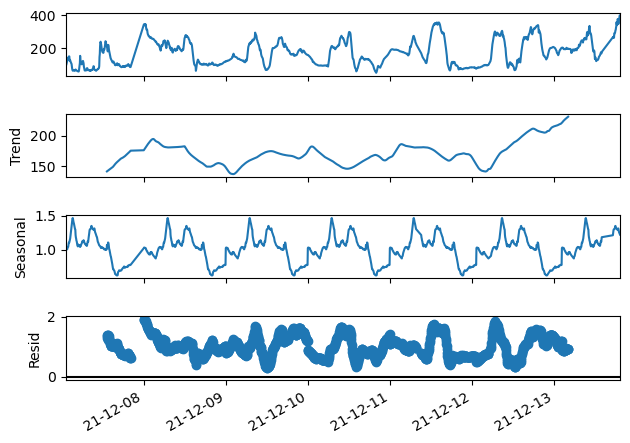

In [ ]:
result_add = seasonal_decompose(week_1_df, period=288, model='additive')
result_add.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)

result_mul = seasonal_decompose(week_1_df, period=288, model='multiplicative')
result_mul.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()

#### Week 2

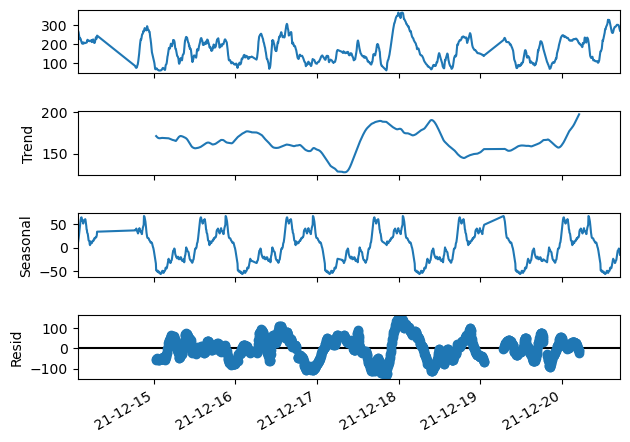

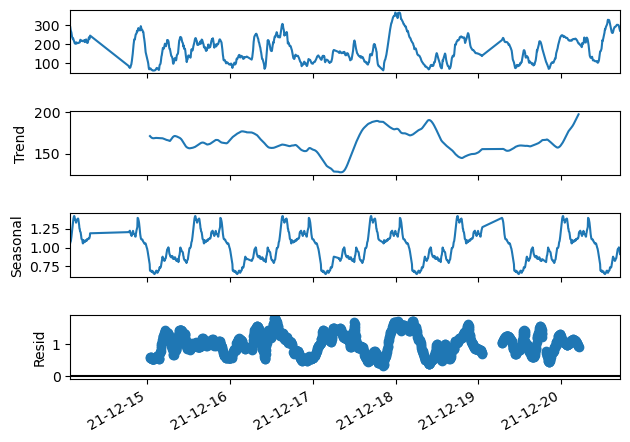

In [ ]:
result_add = seasonal_decompose(week_2_df, period=288, model='additive')
result_add.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)

result_mul = seasonal_decompose(week_2_df, period=288, model='multiplicative')
result_mul.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()

#### Week 3

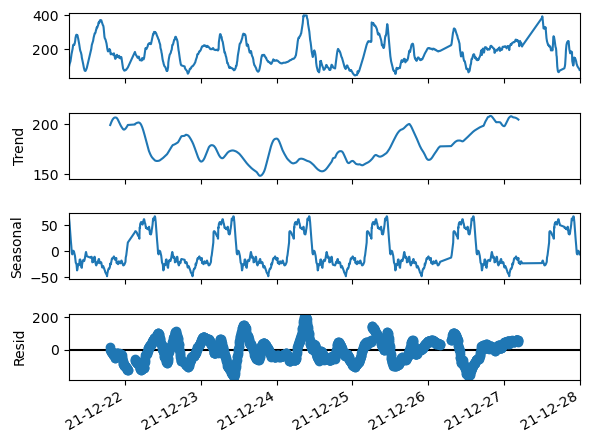

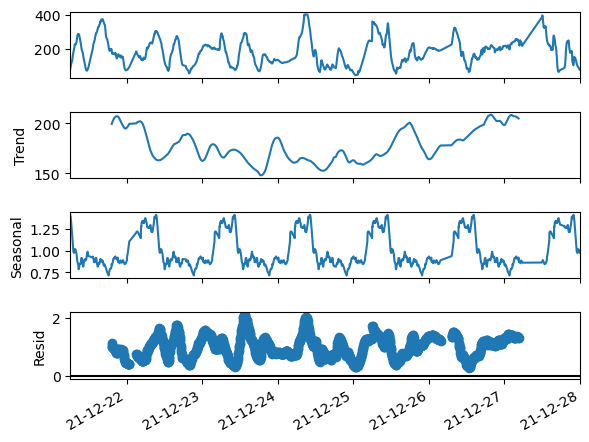

In [ ]:
result_add = seasonal_decompose(week_3_df, period=288, model='additive')
result_add.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)

result_mul = seasonal_decompose(week_3_df, period=288, model='multiplicative')
result_mul.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()

#### Week 4

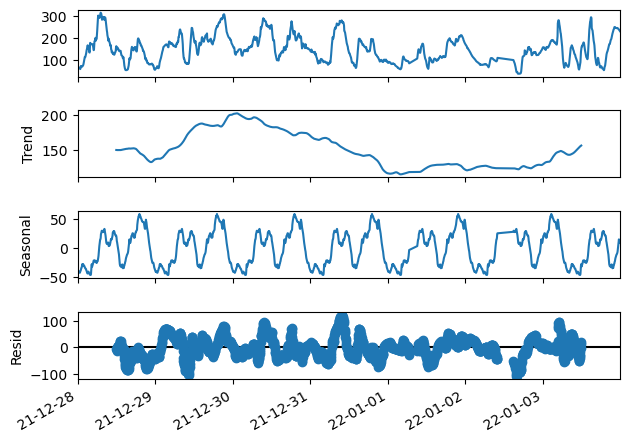

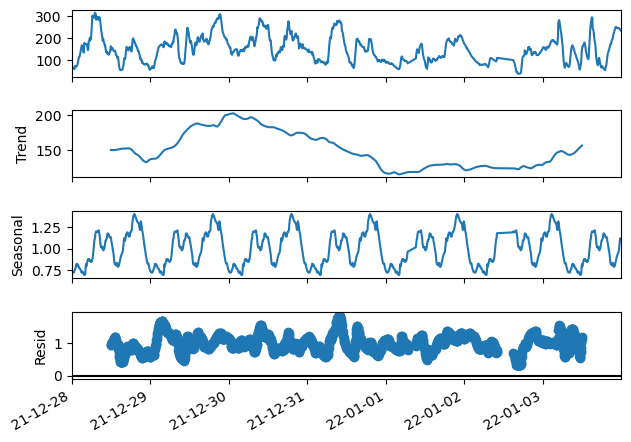

In [ ]:
result_add = seasonal_decompose(week_4_df, period=288, model='additive')
result_add.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)

result_mul = seasonal_decompose(week_4_df, period=288, model='multiplicative')
result_mul.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()

#### Week 5

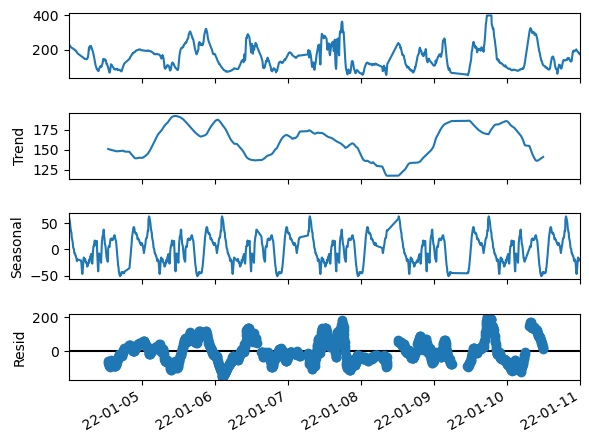

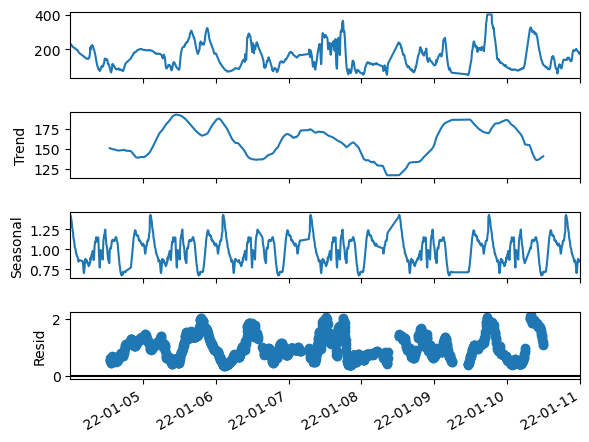

In [ ]:
result_add = seasonal_decompose(week_5_df, period=288, model='additive')
result_add.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)

result_mul = seasonal_decompose(week_5_df, period=288, model='multiplicative')
result_mul.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()

#### Week 6

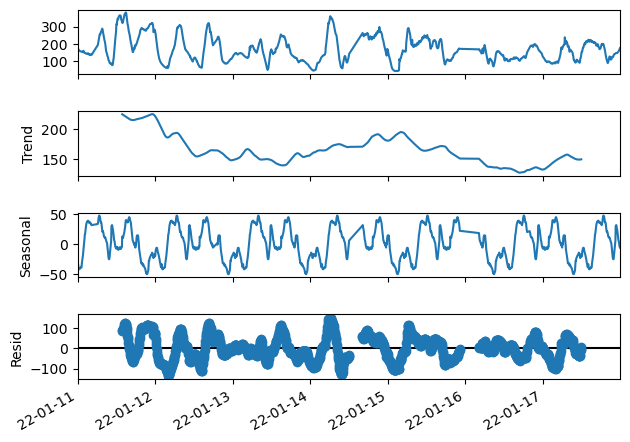

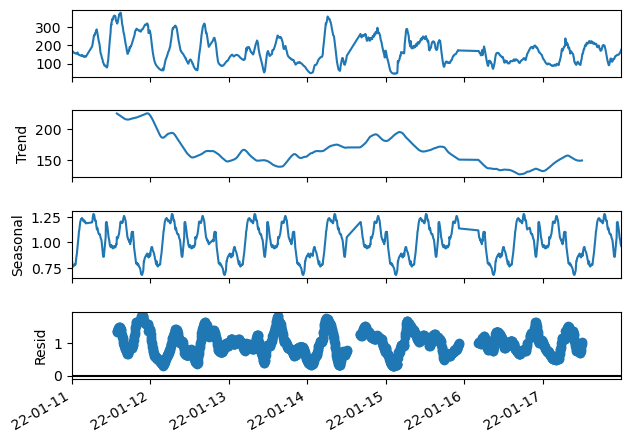

In [ ]:
result_add = seasonal_decompose(week_6_df, period=288, model='additive')
result_add.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)

result_mul = seasonal_decompose(week_6_df, period=288, model='multiplicative')
result_mul.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()

We can notice that there is a daily seasonality. Let's analyse it more precisely.

#### Days of the week 1

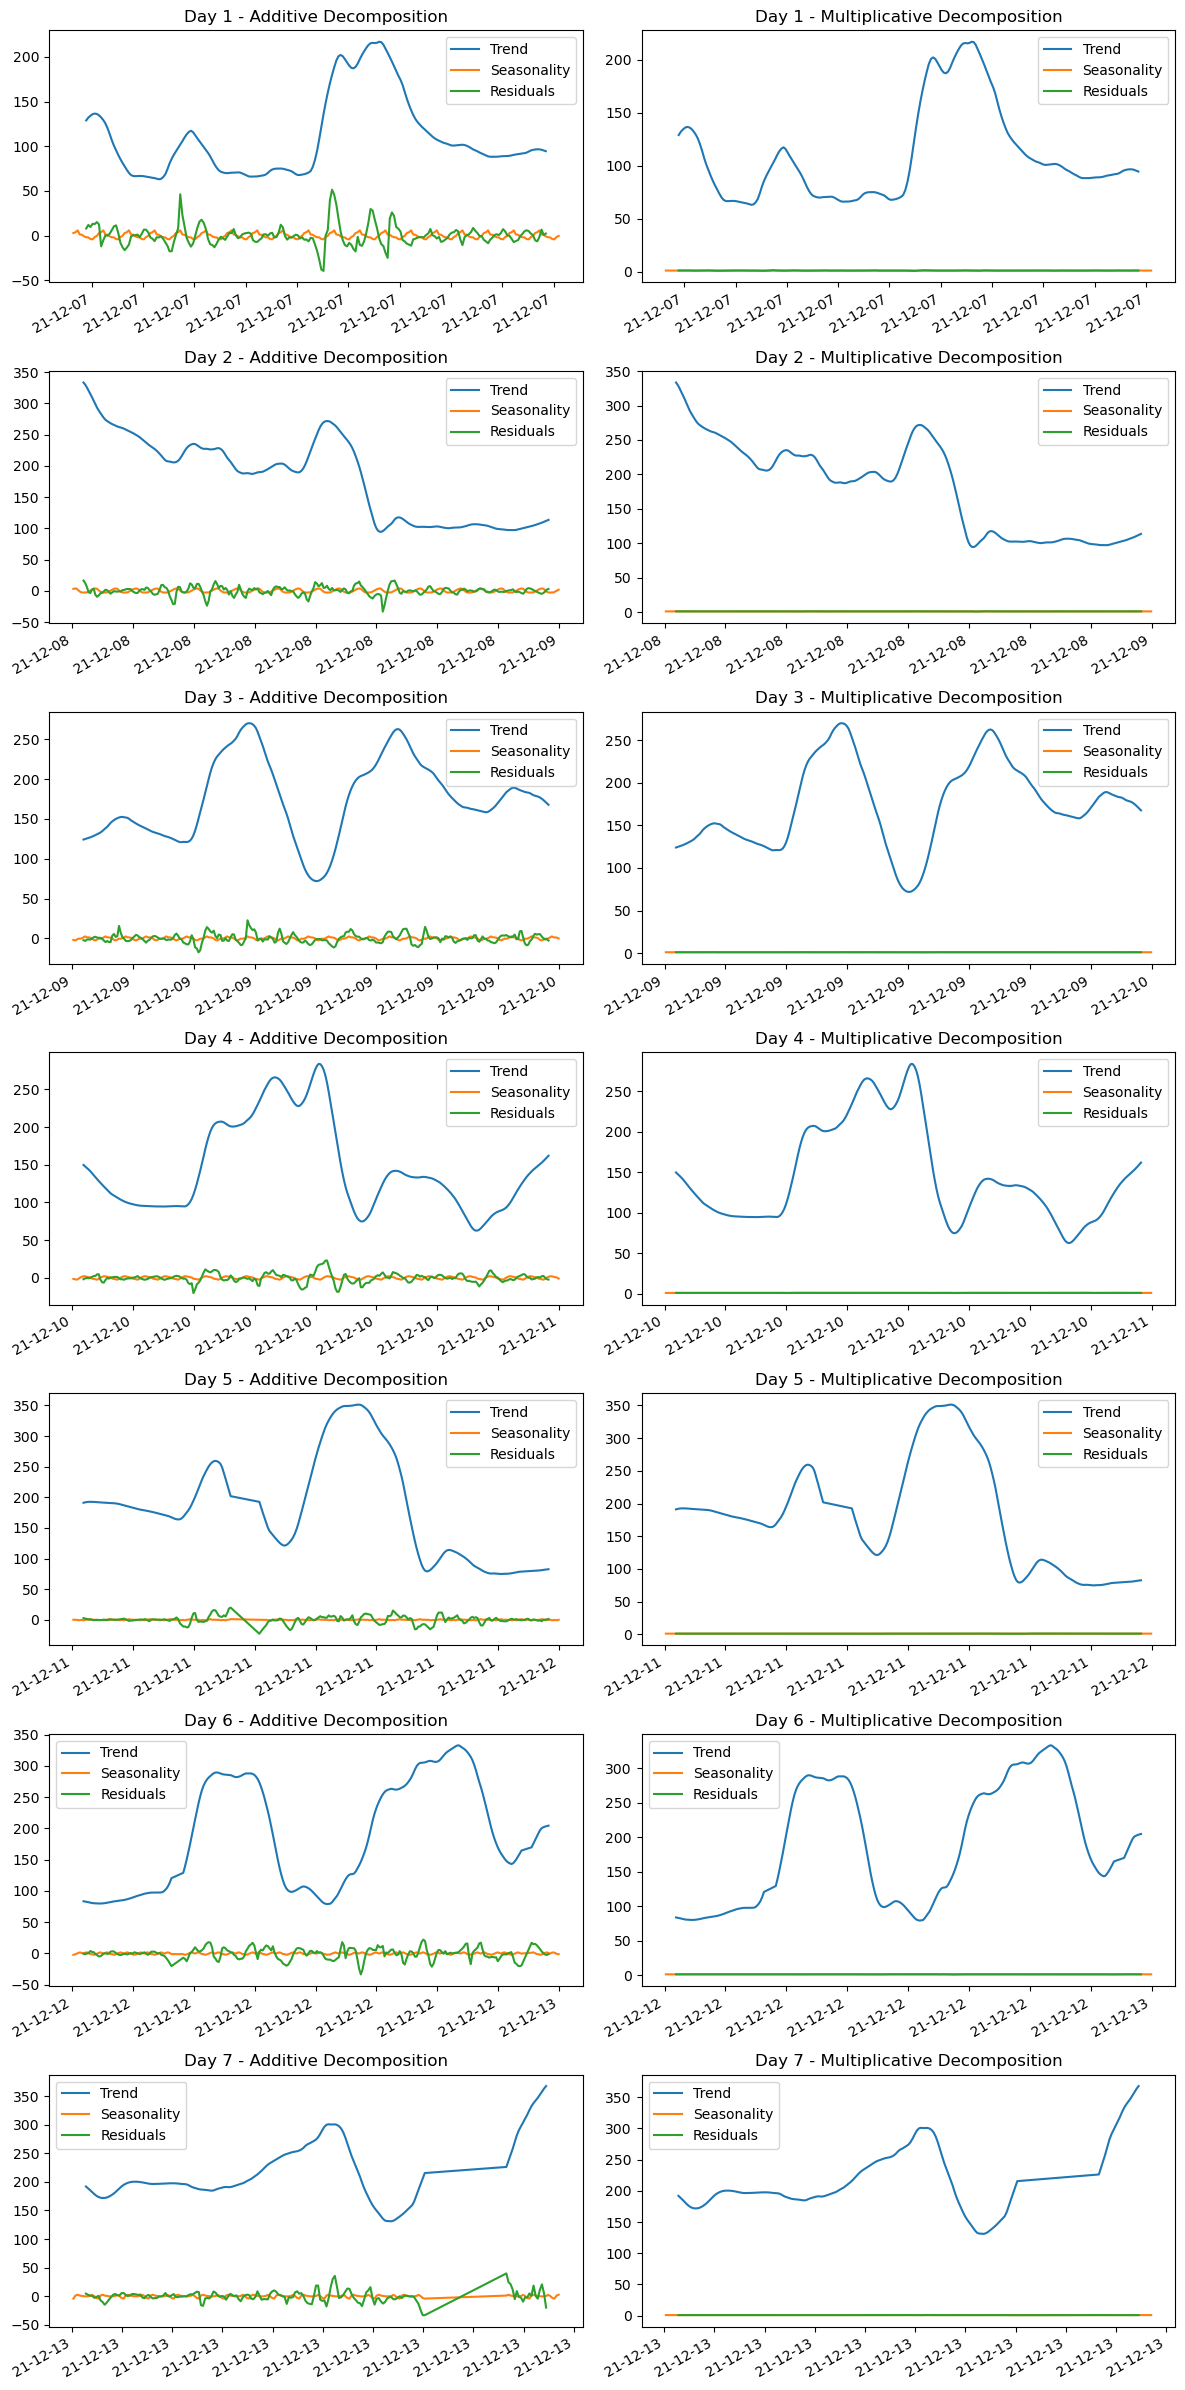

In [ ]:
days_df = [week_1_day_1_df,week_1_day_2_df,week_1_day_3_df,week_1_day_4_df,week_1_day_5_df,week_1_day_6_df,
           week_1_day_7_df]

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(12, 24))

for i, day_df in enumerate(days_df):
        # i = days_df.index(day_df)
        result_add = seasonal_decompose(day_df, period=12, model='additive')
        result_mul = seasonal_decompose(day_df, period=12, model='multiplicative')
        
        axs[i, 0].plot(result_add.trend.index, result_add.trend.values, label='Trend')
        axs[i, 0].plot(result_add.seasonal.index, result_add.seasonal.values, label='Seasonality')
        axs[i, 0].plot(result_add.resid.index, result_add.resid.values, label='Residuals')
        axs[i, 0].set_title(f'Day {i+1} - Additive Decomposition')
        axs[i, 0].legend()
        axs[i, 0].xaxis.set_major_formatter(mpld.DateFormatter('%y-%m-%d'))
        plt.setp(axs[i, 0].get_xticklabels(), rotation=30, ha="right")
        
        axs[i, 1].plot(result_mul.trend.index, result_mul.trend.values, label='Trend')
        axs[i, 1].plot(result_mul.seasonal.index, result_mul.seasonal.values, label='Seasonality')
        axs[i, 1].plot(result_mul.resid.index, result_mul.resid.values, label='Residuals')
        axs[i, 1].set_title(f'Day {i+1} - Multiplicative Decomposition')
        axs[i, 1].legend()
        axs[i, 1].xaxis.set_major_formatter(mpld.DateFormatter('%y-%m-%d'))
        plt.setp(axs[i, 1].get_xticklabels(), rotation=30, ha="right")

plt.tight_layout()
plt.show()




No particular trend nor particular seasonality

### Observations from Seasonal Decompose


1. The time serie seems to have no particular trend
2. A daily seasonality seems to be observed in our data 
